In [1]:
#### ---------------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: July 11, 2025
#### predict individual BRCA Subtype Status using All HoverNet predicted NPIFs and also save the models for external validation
#### ----------------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter, defaultdict
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import random
import joblib

_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)

print(f"working directory = {_wpath_}\n")



working directory = /data/Lab_ruppin/Ranjan/HnE/



In [2]:
# Define dataset and file paths
dataset_name = "Direct_features"
outcome_names = ["HER2_Status", "PR_Status", "ER_Status"]

# File paths
Direct_features_with_BRCA_status_file = "/data/Ruppin_AI/Datasets/TCGA_BRCA_FFPE/TCGA_BRCA_Subtypes/data/BrcaSubtypesToDeePT.csv"

# Output path to save results and plots
out_path = f"{dataset_name}/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/"
model_save_path = os.path.join(out_path, "saved_models/")
os.makedirs(model_save_path, exist_ok=True) # Creates directory if it doesn't exist already

# read files 
Direct_features_with_BRCA_status_full = pd.read_csv(Direct_features_with_BRCA_status_file)

# Remove trailing spaces from column names
Direct_features_with_BRCA_status_full.columns = Direct_features_with_BRCA_status_full.columns.str.strip()
Direct_features_with_BRCA_status_full

# Rename 'sampleID' to 'sample_id'
Direct_features_with_BRCA_status_full = Direct_features_with_BRCA_status_full.rename(columns={'sampleID': 'sample_id',
    'HER2_Final_Status_nature2012': 'HER2_Status',
    'PR_Status_nature2012': 'PR_Status',
    'ER_Status_nature2012': 'ER_Status'})
Direct_features_with_BRCA_status_full

# The number of samples used for TCGA BRCA subtype prediction 
TCGA_BRCA_Subtypes_556_file = "TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/outputs_biomarker_status_prediction_results_All_HoverNet_NPIFs/combined_class_predictions_all_features_for_subtypes.csv"

TCGA_BRCA_Subtypes_556 = pd.read_csv(TCGA_BRCA_Subtypes_556_file)

# Convert the first column ("sample") to a series
sample_list_556 = TCGA_BRCA_Subtypes_556['sample_id'].reset_index(drop=True)

# Filter sample based on `sample_list_556`
Direct_features_with_BRCA_status_full = Direct_features_with_BRCA_status_full[Direct_features_with_BRCA_status_full['sample_id'].isin(sample_list_556)].copy()

# Convert the first column ("sample") to a series
patient_list = Direct_features_with_BRCA_status_full['sample_id'].reset_index(drop=True)

# Filter to include only rows where outcome is "Positive" or "Negative"
data_filtered = Direct_features_with_BRCA_status_full[
    Direct_features_with_BRCA_status_full[outcome_names].isin(["Positive", "Negative"]).all(axis=1)
]


# Filter out the patient list
filtered_patient_list = data_filtered['sample_id'].reset_index(drop=True)



Direct_features_with_BRCA_status_full
filtered_patient_list
data_filtered

,level_0,sample_id,HER2_Status,PR_Status,ER_Status,BRCA_Subtypes,index,Unnamed: 0,project_id_x,case_submitter_id,...,B4d1_supertype,B4d2_supertype,C4d1_supertype,C4d2_supertype,A4d1_supertype_label,A4d2_supertype_label,B4d1_supertype_label,B4d2_supertype_label,C4d1_supertype_label,C4d2_supertype_label
0,0,TCGA-A1-A0SB,Negative,Negative,Positive,HR Positive,8,8,TCGA-BRCA,TCGA-A1-A0SB,...,35.0,44.0,4.0,5.0,3.0,6.0,8.0,15.0,3.0,4.0
1,1,TCGA-A1-A0SD,Negative,Positive,Positive,HR Positive,9,9,TCGA-BRCA,TCGA-A1-A0SD,...,35.0,35.0,4.0,4.0,5.0,7.0,8.0,8.0,3.0,3.0
2,2,TCGA-A1-A0SE,Negative,Positive,Positive,HR Positive,10,10,TCGA-BRCA,TCGA-A1-A0SE,...,15.0,51.0,7.0,14.0,1.0,10.0,4.0,22.0,6.0,9.0
3,3,TCGA-A1-A0SF,Negative,Positive,Positive,HR Positive,11,11,TCGA-BRCA,TCGA-A1-A0SF,...,14.0,58.0,7.0,8.0,1.0,9.0,3.0,29.0,6.0,7.0
4,4,TCGA-A1-A0SH,Negative,Positive,Negative,HR Positive,12,12,TCGA-BRCA,TCGA-A1-A0SH,...,8.0,27.0,2.0,7.0,0.0,1.0,1.0,6.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,754,TCGA-EW-A1PB,Negative,Negative,Negative,TNBC,983,983,TCGA-BRCA,TCGA-EW-A1PB,...,39.0,44.0,12.0,16.0,8.0,10.0,11.0,15.0,8.0,11.0
704,755,TCGA-EW-A1PD,Positive,Positive,Positive,HER2 Positive,985,985,TCGA-BRCA,TCGA-EW-A1PD,...,14.0,55.0,3.0,8.0,7.0,8.0,3.0,26.0,2.0,7.0
705,756,TCGA-EW-A1PE,Negative,Positive,Positive,HR Positive,986,986,TCGA-BRCA,TCGA-EW-A1PE,...,35.0,40.0,3.0,12.0,1.0,5.0,8.0,12.0,2.0,8.0
706,757,TCGA-EW-A1PF,Negative,Positive,Positive,HR Positive,987,987,TCGA-BRCA,TCGA-EW-A1PF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# load features
features = np.loadtxt("/data/Ruppin_AI/Datasets/TCGA_BRCA_FFPE/TCGA_BRCA_Subtypes/data/resnet50_features_for_subtypes.txt")

features.shape

X = features

X

array([[1.46061659, 1.11716211, 1.19756579, ..., 1.44734418, 1.53642333,
        1.24243522],
       [1.70845091, 1.26295209, 1.20699382, ..., 1.44604373, 1.5387094 ,
        1.51889575],
       [1.31104529, 1.17559111, 1.13367248, ..., 1.28130949, 1.63089681,
        1.10628188],
       ...,
       [1.60605299, 1.24047041, 1.04987669, ..., 1.40182972, 1.32679892,
        1.35360467],
       [1.98110902, 1.12026405, 1.12523699, ..., 1.25709438, 1.69813025,
        1.55519426],
       [1.54666352, 1.05866075, 0.91102624, ..., 1.27106333, 1.60993564,
        1.19872665]])

In [4]:
# Initialize a DataFrame to store the combined results
combined_results_df = pd.DataFrame({'sample_id': filtered_patient_list.values})
combined_results_df.set_index('sample_id', inplace=True)

# Define hyperparameter grid for Logistic Regression with L2 penalty (Ridge)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Define cross-validation parameters
n_folds = 5
seed = 20852
shuffle = True

# Define subtype names
subtype_names_3 = ['HER2_Positive', 'HR_Positive', 'TNBC_3']
subtype_names_4 = ['HR+', 'TNBC_4', 'TPBC', 'HER2+']
all_subtype_names = subtype_names_3 + subtype_names_4

# Step 1: Define true subtypes from HER2/ER/PR status
def define_true_subtypes(df):
    HER2 = df['HER2_Status'] == 'Positive'
    ER = df['ER_Status'] == 'Positive'
    PR = df['PR_Status'] == 'Positive'

    df['HER2_Positive'] = HER2.astype(int)
    df['HR_Positive'] = ((ER | PR) & ~HER2).astype(int)
    df['TNBC_3'] = (~HER2 & ~ER & ~PR).astype(int)

    df['HR+'] = (ER & ~HER2).astype(int)
    df['TNBC_4'] = (~ER & ~HER2).astype(int)
    df['TPBC'] = (ER & HER2).astype(int)
    df['HER2+'] = (~ER & HER2).astype(int)

    return df

# Apply subtype definition
data_filtered = define_true_subtypes(data_filtered)
X

array([[1.46061659, 1.11716211, 1.19756579, ..., 1.44734418, 1.53642333,
        1.24243522],
       [1.70845091, 1.26295209, 1.20699382, ..., 1.44604373, 1.5387094 ,
        1.51889575],
       [1.31104529, 1.17559111, 1.13367248, ..., 1.28130949, 1.63089681,
        1.10628188],
       ...,
       [1.60605299, 1.24047041, 1.04987669, ..., 1.40182972, 1.32679892,
        1.35360467],
       [1.98110902, 1.12026405, 1.12523699, ..., 1.25709438, 1.69813025,
        1.55519426],
       [1.54666352, 1.05866075, 0.91102624, ..., 1.27106333, 1.60993564,
        1.19872665]])

In [5]:
# Initialize result storage
results = {}
mean_f1_scores = []

# Loop through each subtype
for subtype in all_subtype_names:
    print(f"\nProcessing subtype: {subtype}")
    
    y = data_filtered[subtype].values  # ensure NumPy array
    y_encoded = y.copy()

    outer_results = []
    y_true_all_folds = []
    predictions = []
    f1_scores = []

    outer_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
    fold_idx = 1

    for train_idx, test_idx in outer_cv.split(X, y_encoded):
        print(f"\nOuter Fold {fold_idx}/{n_folds}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
        patient_test_ids = filtered_patient_list.iloc[test_idx]

        # Print class balance
        print("Train class dist:", dict(pd.Series(y_train).value_counts()))
        print("Test class dist :", dict(pd.Series(y_test).value_counts()))

        inner_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)

        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', LogisticRegression(penalty='l1', solver='saga',
                                              class_weight='balanced', max_iter=10000))
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters: {best_params}")

        # Save model
        model_filename = os.path.join(model_save_path, f"{subtype}_model_fold_{fold_idx}.joblib")
        joblib.dump(best_model, model_filename)
        print(f"Saved model with scaler: {model_filename}")

        # Predict
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        predictions.append(y_pred_proba)
        y_true_all_folds.extend(y_test)

        # Save predictions to results DataFrame
        combined_results_df.loc[patient_test_ids.values, f'true_label_{subtype}'] = y_test
        combined_results_df.loc[patient_test_ids.values, f'predicted_probability_{subtype}'] = y_pred_proba

        # Evaluate
        f1 = f1_score(y_test, (y_pred_proba >= 0.5).astype(int))
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1_scores.append(f1)

        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC : {roc_auc:.4f}")

        outer_results.append({
            'fold': fold_idx,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'best_params': best_params
        })

        fold_idx += 1

    # Save results
    mean_f1_score = np.mean(f1_scores)
    print(f"Mean F1-score for {subtype}: {mean_f1_score:.4f}")

    results[subtype] = {
        'outer_results': outer_results,
        'mean_f1_score': mean_f1_score,
        'best_params': best_params
    }
    mean_f1_scores.append(mean_f1_score)



Processing subtype: HER2_Positive

Outer Fold 1/5
Train class dist: {0: 378, 1: 66}
Test class dist : {0: 95, 1: 17}
Best parameters: {'classifier__C': 1}
Saved model with scaler: Direct_features/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/saved_models/HER2_Positive_model_fold_1.joblib
F1-score: 0.3600
ROC AUC : 0.7703

Outer Fold 2/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 10}
Saved model with scaler: Direct_features/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/saved_models/HER2_Positive_model_fold_2.joblib
F1-score: 0.3721
ROC AUC : 0.6336

Outer Fold 3/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 10}
Saved model with scaler: Direct_features/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/saved_models/HER2_Positive_model_fold_3.joblib
F1-score: 0.4667
ROC AUC : 0.8072

Outer Fold 4/5
Train class dist: {0

/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 1}
Saved model with scaler: Direct_features/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/saved_models/HER2+_model_fold_4.joblib
F1-score: 0.2857
ROC AUC : 0.8528

Outer Fold 5/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}
Best parameters: {'classifier__C': 100}
Saved model with scaler: Direct_features/outputs/Prediction_results_PathAI_Direct_Features_Binary_Subtypes/saved_models/HER2+_model_fold_5.joblib
F1-score: 0.0000
ROC AUC : 0.6038
Mean F1-score for HER2+: 0.1371


In [6]:
# Save combined prediction outputs
combined_results_df.to_csv(os.path.join(out_path, 'combined_class_predictions_all_subtypes_binary.csv'), index=True)
combined_results_df

,true_label_HER2_Positive,predicted_probability_HER2_Positive,true_label_HR_Positive,predicted_probability_HR_Positive,true_label_TNBC_3,predicted_probability_TNBC_3,true_label_HR+,predicted_probability_HR+,true_label_TNBC_4,predicted_probability_TNBC_4,true_label_TPBC,predicted_probability_TPBC,true_label_HER2+,predicted_probability_HER2+
sample_id,,,,,,,,,,,,,,
TCGA-A1-A0SB,0.0,0.000013,1.0,0.947905,0.0,0.993394,1.0,0.445527,0.0,0.991959,0.0,1.101012e-08,0.0,0.000006
TCGA-A1-A0SD,0.0,0.129850,1.0,0.667836,0.0,0.251136,1.0,0.667124,0.0,0.887228,0.0,9.437141e-03,0.0,0.000237
TCGA-A1-A0SE,0.0,0.168590,1.0,0.997513,0.0,0.032298,1.0,0.997911,0.0,0.000850,0.0,1.531491e-06,0.0,0.032802
TCGA-A1-A0SF,0.0,0.165809,1.0,0.910100,0.0,0.006967,1.0,0.775927,0.0,0.395623,0.0,5.315405e-03,0.0,0.007708
TCGA-A1-A0SH,0.0,0.002196,1.0,0.917127,0.0,0.107515,0.0,0.951727,1.0,0.089494,0.0,1.591170e-06,0.0,0.004226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EW-A1PB,0.0,0.699521,0.0,0.000008,1.0,0.891762,0.0,0.090359,1.0,0.922704,0.0,7.309817e-05,0.0,0.350280
TCGA-EW-A1PD,1.0,0.285383,0.0,0.622884,0.0,0.321341,0.0,0.667258,0.0,0.252993,1.0,3.304749e-01,0.0,0.065688
TCGA-EW-A1PE,0.0,0.472403,1.0,0.920319,0.0,0.064839,1.0,0.640715,0.0,0.066812,0.0,9.210976e-01,0.0,0.005961


In [7]:
# Mapping for 3-subtype ROC plotting
subtypes_3 = {
    'HER2_Positive': ('true_label_HER2_Positive', 'predicted_probability_HER2_Positive'),
    'HR_Positive': ('true_label_HR_Positive', 'predicted_probability_HR_Positive'),
    'TNBC_3': ('true_label_TNBC_3', 'predicted_probability_TNBC_3')
}

# Mapping for 4-subtype ROC plotting
subtypes_4 = {
    'HR+': ('true_label_HR+', 'predicted_probability_HR+'),
    'TNBC_4': ('true_label_TNBC_4', 'predicted_probability_TNBC_4'),
    'TPBC': ('true_label_TPBC', 'predicted_probability_TPBC'),
    'HER2+': ('true_label_HER2+', 'predicted_probability_HER2+')
}


In [8]:
colors = {
    'HER2_Positive': 'darkorange',
    'HR_Positive': 'blue',
    'TNBC_3': 'green',
    'HR+': 'blue',
    'TNBC_4': 'green',
    'TPBC': 'tomato',
    'HER2+': 'darkorange'
}
def plot_combined_roc_curves(df, subtypes, title, filename):
    plt.figure(figsize=(10, 8))
    total_samples = len(df)

    for subtype, (true_label_col, pred_prob_col) in subtypes.items():
        if subtype in ['TNBC_3', 'TNBC_4']:
            if 'TNBC' in colors:  # Avoid duplicated legend for TNBC
                continue
            label = 'TNBC'
        elif subtype == 'HER2_Positive':
            label = 'HER2+'
        elif subtype == 'HR_Positive':
            label = 'HR+'
        else:
            label = subtype

        # Filter valid entries
        valid_indices = (~df[true_label_col].isna()) & (~df[pred_prob_col].isna())
        true_labels = df[true_label_col][valid_indices]
        predicted_probs = df[pred_prob_col][valid_indices]

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=colors[subtype], lw=2,
                 label=f'{label} (AUC = {roc_auc:.2f}, n = {true_labels.sum():.0f})')

    # Reference diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)

    # Save and show
    plt.savefig(os.path.join(out_path, filename), bbox_inches='tight')
    plt.show()


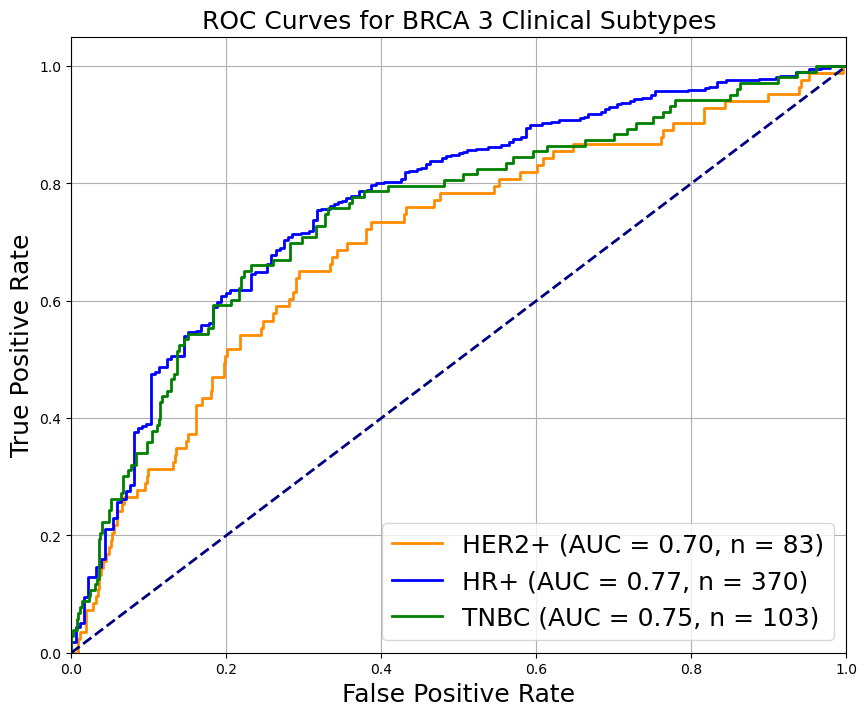

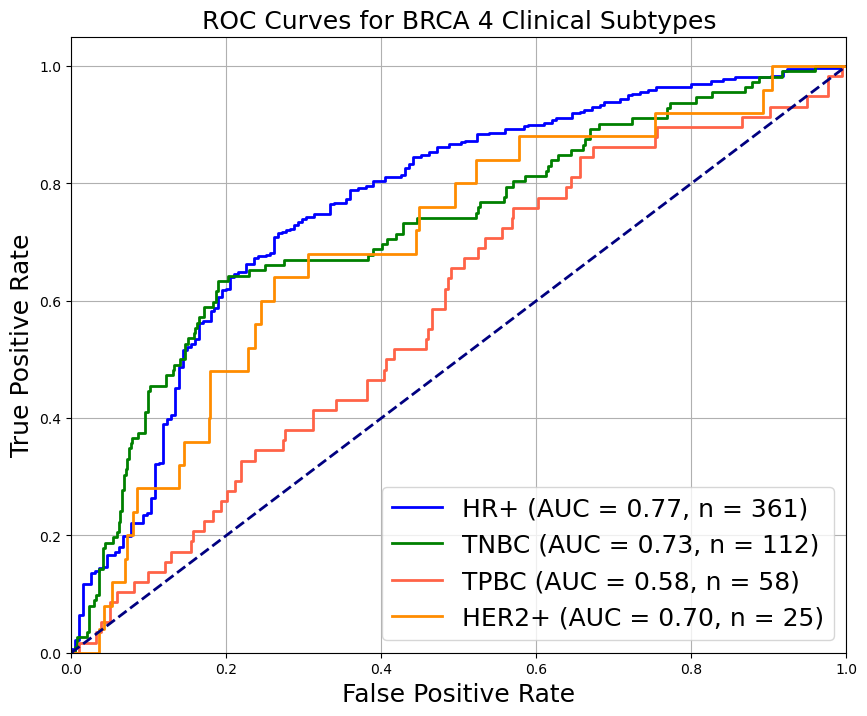

In [9]:
plot_combined_roc_curves(
    combined_results_df,
    subtypes_3,
    'ROC Curves for BRCA 3 Clinical Subtypes',
    'roc_3_subtypes.png'
)

plot_combined_roc_curves(
    combined_results_df,
    subtypes_4,
    'ROC Curves for BRCA 4 Clinical Subtypes',
    'roc_4_subtypes.png'
)

